# **Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [55]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [56]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [57]:
%%bash
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L5EEsunpAoHEnRNa8guN-KgjI8V9heBR' -O Wongnai_Reviews_Small.csv

--2021-11-14 11:23:28--  https://docs.google.com/uc?export=download&id=1L5EEsunpAoHEnRNa8guN-KgjI8V9heBR
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.139, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rkjmqduqq4a5qav7n60sj332ssu95aov/1636888950000/09104690438019172937/*/1L5EEsunpAoHEnRNa8guN-KgjI8V9heBR?e=download [following]
--2021-11-14 11:23:29--  https://doc-0k-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rkjmqduqq4a5qav7n60sj332ssu95aov/1636888950000/09104690438019172937/*/1L5EEsunpAoHEnRNa8guN-KgjI8V9heBR?e=download
Resolving doc-0k-bk-docs.googleusercontent.com (doc-0k-bk-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-bk-docs.googleusercontent.com (doc-0k-bk-d

In [1]:
import pandas as pd
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [2]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


# **Step 1 - document embedding and dimension reduction**

In [109]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

TypeError: ignored

In [110]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=25)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

# **Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

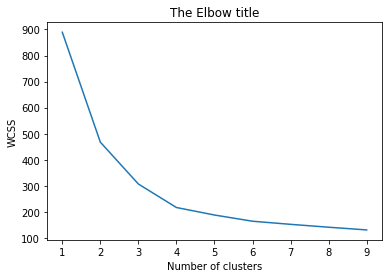

In [111]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [158]:
#run kmeans with no. of clusters you see fit the most

k = 7

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [159]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [160]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,18 เคยทานทองม้วนสดมาหลายร้านแล้ว \nถ้าจะทา...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
4,4,4 ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใ...
5,5,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...
6,6,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [161]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [174]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'รีวิว', 'วัง', 'ทาน', 'รส', 'สาขา', 'ผม', 'ซื้อ', 'กิน', 'า', 'อร่อย', 'นะคะ', 'สำหรับ', 'หา', 'เด', 'ห', 'หาย', 'ซอย', '']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "ชานมไข่มุก", "ยำแซ่บ", "โรบัสต้า", "ชาไข่มุก", "อเมซอน", "แวะจิบ", "หัวหิน", "ชานมไต้หวัน", "ไข่เป็ด", "คอกาแฟ", 'รสชาติดี', 'ท้องม้วนสด'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='longest', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [175]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [176]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[ก, วง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ,...","[(ร้านอาหาร, 6), (กก, 6), (อาหาร, 5), (ราคา, 4..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, macchiato, เป็นประจำ, นึง, artofcoff...","[(ร้านกาแฟ, 12), (กาแฟ, 11), (คน, 4), (ชอบ, 3)..."
2,2,เคยทานทองม้วนสดมาหลายร้านแล้วnถ้าจะทานแบบอร่เช...,"[ทองม้วน, สด, อร่, เช้าๆ, บ่ายๆ, เย็นๆ, อาหารว...","[(คาเฟ่, 3), (ชอบ, 3), (พาย, 3), (จริณ, 2), (เ..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่ระ...,"[ไหม, ไหม, หลังอาหาร, มื้อ, อิ่, มุ่งหน้า, ชัย...","[(ชานมไข่มุก, 9), (ชา, 5), (เครื่องดื่ม, 4), (..."
4,4,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,"[ชอบ, อาหาร, เวียดนาม, บ้าน, ส้มตำ, เจ๊, พิม, ...","[(ร้านอาหาร, 6), (บ้าน, 3), (ส้มตำ, 3), (ถนน, ..."
5,5,โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่...,"[โลตัส, พัฒนาการ, ชี, ท, เค้ก, หม่ำ, นึง, ค่, ...","[(ร้านกาแฟ, 10), (กาแฟ, 6), (เค้ก, 3), (ชั้น, ..."
6,6,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, ออกมา, อะ, ไเป็น,...","[(ร้านอาหาร, 4), (ร้านกาแฟ, 4), (ครั้งแรก, 3),..."


In [177]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 6), ('กก', 6), ('อาหาร', 5), ('ราคา', 4), ('ก', 3), ('สวัสดี', 3), ('นอ', 3), ('รา', 3), ('รอบ', 3), ('หาร', 3), ('รสชาติ', 3), ('กาแฟ', 3), ('วง', 2), ('เพื่อนๆ', 2), ('หัวหิน', 2), ('ไร้', 2), ('บ้าน', 2), ('ไทย', 2), ('แพง', 2), ('อาศัย', 2)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 12), ('กาแฟ', 11), ('คน', 4), ('ชอบ', 3), ('นึง', 3), (':', 3), ('นั่ง', 3), ('ร้า', 3), ('สวัสดี', 3), ('เจอ', 3), ('อย', 3), ('ดี', 3), ('รสชาติ', 2), ('เดือน', 2), ('เหมือน', 2), ('มาจาก', 2), ('ส่วนตัว', 2), ('รอ', 2), ('พัก', 2), ('เดินผ่าน', 2)]

Cluster ID : 2

Most common words include : [('คาเฟ่', 3), ('ชอบ', 3), ('พาย', 3), ('จริณ', 2), ('เบเกอรี่', 2), ('พัน', 2), ('น้ำ', 2), ('ปั่น', 2), ('แตงโม', 2), ('ทองม้วน', 1), ('สด', 1), ('อร่', 1), ('เช้าๆ', 1), ('บ่ายๆ', 1), ('เย็นๆ', 1), ('อาหารว่าง', 1), ('คนเรา', 1), ('หยิบ', 1), ('จัา', 1), ('นพ', 1)]

Cluster ID : 3

Most common words include : [('ชานมไข่มุก', 9), ('ชา'

# result discussion

Cluster 0 : ร้านอาหาร แถวหัวหิน ราคาแพง

Cluster 1 : ร้านกาแฟนั่งชิล

Cluster 2 : คาเฟ่ ขนม ของหวาน

Cluster 3 : คนรักชานม

Cluster 4 : ร้านอาหาร เก่าแก่ พัทยา

Cluster 5 : ร้านกาแฟ และเบอเกอรี่ บรรยากาศดี

Cluster 6 : ร้านอาหาร และ ร้านกาแฟ แนะนำให้ลอง
